In [1]:
# Import Global Dependencies
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import gmaps

In [2]:
#insert personal API keys into these scripts
from api_keys import api_key     #openweathermap API
from config import gkey       #API with Google Places & Maps Javascript need to be enabled

In [3]:
############Lon_Lat_Collection##################

url = "http://api.openweathermap.org/data/2.5/weather?"

#Read in Zillow City / Median Pricing Data
city_csv = pd.read_csv('datasets/Median_Sale_Rental.csv')
city_coords = dict()

#Loop Through Top 100 City/Metro Areas
for city in city_csv['City']:
    query_url = f"{url}appid={api_key}&q={city},US"
    weather_response = requests.get(query_url)
    weather_json = weather_response.json()
    city_coords[city] = [weather_json["coord"]["lon"],weather_json["coord"]["lat"]]

#Merge Lon / Lat Info from API with Zillow Data
top100_cities = pd.DataFrame.from_dict(city_coords,orient='index')
top100_cities.index.name = 'City'
combined_data = city_csv.merge(top100_cities,on="City")
combined_data.head()

#Organize Data, rename some columns
combined_data = combined_data.rename(columns={0:"lon",1:"lat"})
combined_data = combined_data[["Rank","City","State","lon","lat","CityState","Median Sale","Median Rent"]]
combined_data.head()

,Rank,City,State,lon,lat,CityState,Median Sale,Median Rent
0,1,New York,NY,-73.99,40.73,"New York, NY",391300,3000
1,2,Los Angeles,CA,-118.24,34.05,"Los Angeles, CA",629800,3200
2,3,Chicago,IL,-87.62,41.88,"Chicago, IL",246500,1750
3,4,Dallas,TX,-96.80,32.78,"Dallas, TX",257600,1750
4,5,Philadelphia,PA,-75.16,39.95,"Philadelphia, PA",218600,1600


In [4]:
#Output to csv
combined_data.to_csv('datasets/top100_median.csv',index=False)

In [5]:
############Get_Whole_Foods##################

## Global Parameters - stay the same for each API call

# first parameter - keyword
keyword = 'Whole%20Foods'

# second parameter - 15 km search radius
radius = '15000'

 
# read csv
with open('datasets/top100_median.csv') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    csv_header = next(csvreader)
    
    numWF = [] #list of numbers of whole foods
    
    # Looping through csv by row, calling API for each city
    for row in csvreader:
        
        # third parameter - latlng coordinates - change for each API call
        coor = row[4] + "," + row[3]
        
        # Call Google Places API with parameters
        base_url = f"https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={coor}&radius={radius}&keyword={keyword}&key={gkey}"  
        
        response = requests.get(base_url)
        places_data = response.json()    #outputs json
        
        city_WF = len(places_data['results']) # number of whole foods in given city
        
        numWF.append(city_WF) #append to overall list

In [6]:
# Read csv with pandas, append numWF, and write to new csv with pandas
my_cities_df = pd.read_csv('datasets/top100_median.csv')
my_cities_df["# of Whole Foods (15km radius)"] = numWF
my_cities_df = my_cities_df.drop(columns = ["Rank"])
my_cities_df.to_csv('datasets/top100_median_with_wf.csv',index=False)

In [7]:
############City_Housing_Graphs##################

# Load in csv
city_df = pd.read_csv("datasets/top100_median_with_wf.csv")
city_df.head()

,City,State,lon,lat,CityState,Median Sale,Median Rent,# of Whole Foods (15km radius)
0,New York,NY,-73.99,40.73,"New York, NY",391300,3000,20
1,Los Angeles,CA,-118.24,34.05,"Los Angeles, CA",629800,3200,9
2,Chicago,IL,-87.62,41.88,"Chicago, IL",246500,1750,15
3,Dallas,TX,-96.80,32.78,"Dallas, TX",257600,1750,10
4,Philadelphia,PA,-75.16,39.95,"Philadelphia, PA",218600,1600,7


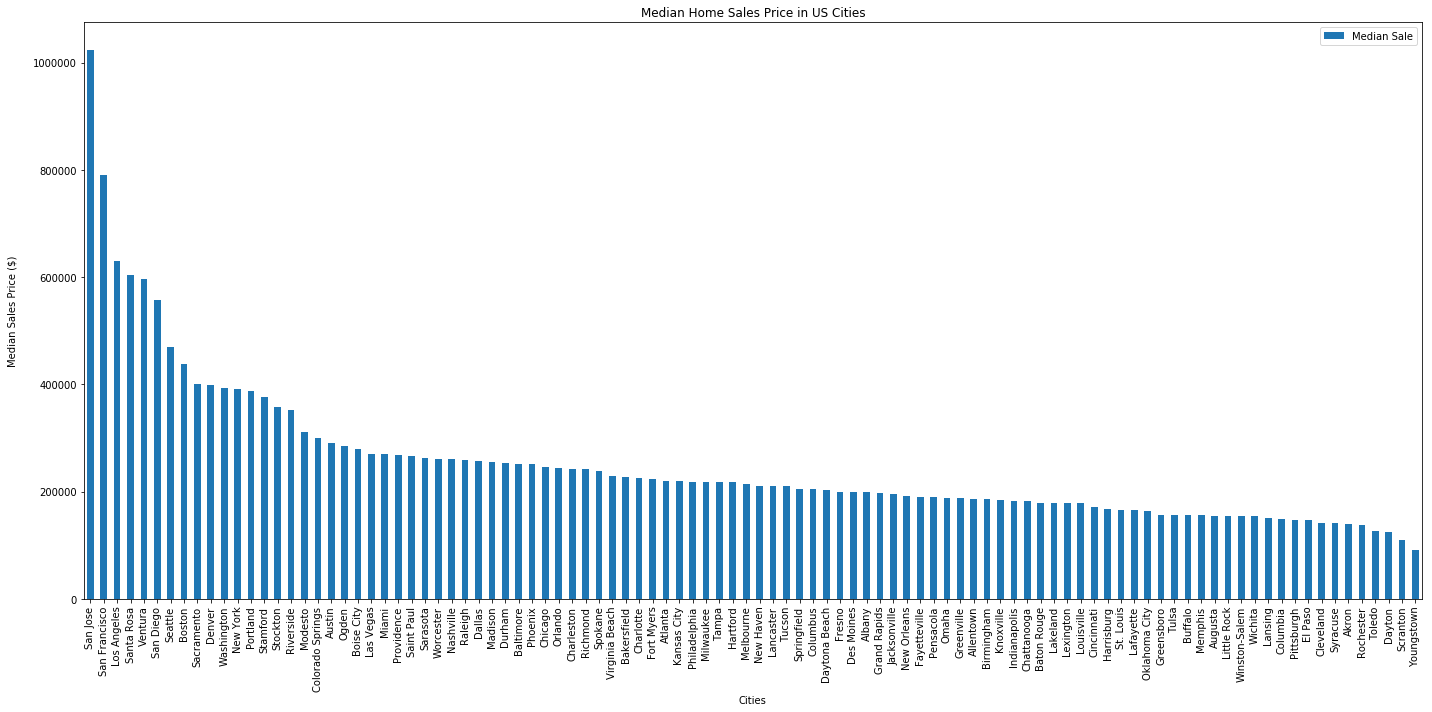

In [8]:
#Median Home Sales Price VS Cities
city_df = city_df.sort_values(by=['Median Sale'], ascending=False) #sorted by median sales
city_df.plot(kind = "bar", x = "City", y= "Median Sale", figsize =(20,10)).set_ylabel("Median Sales Price($)")
plt.title("Median Home Sales Price in US Cities")
plt.xlabel("Cities")
plt.ylabel("Median Sales Price ($)\n")
plt.tight_layout()
plt.savefig("images/Median Home Sales Price.png", bbox_inches = "tight")
plt.show()

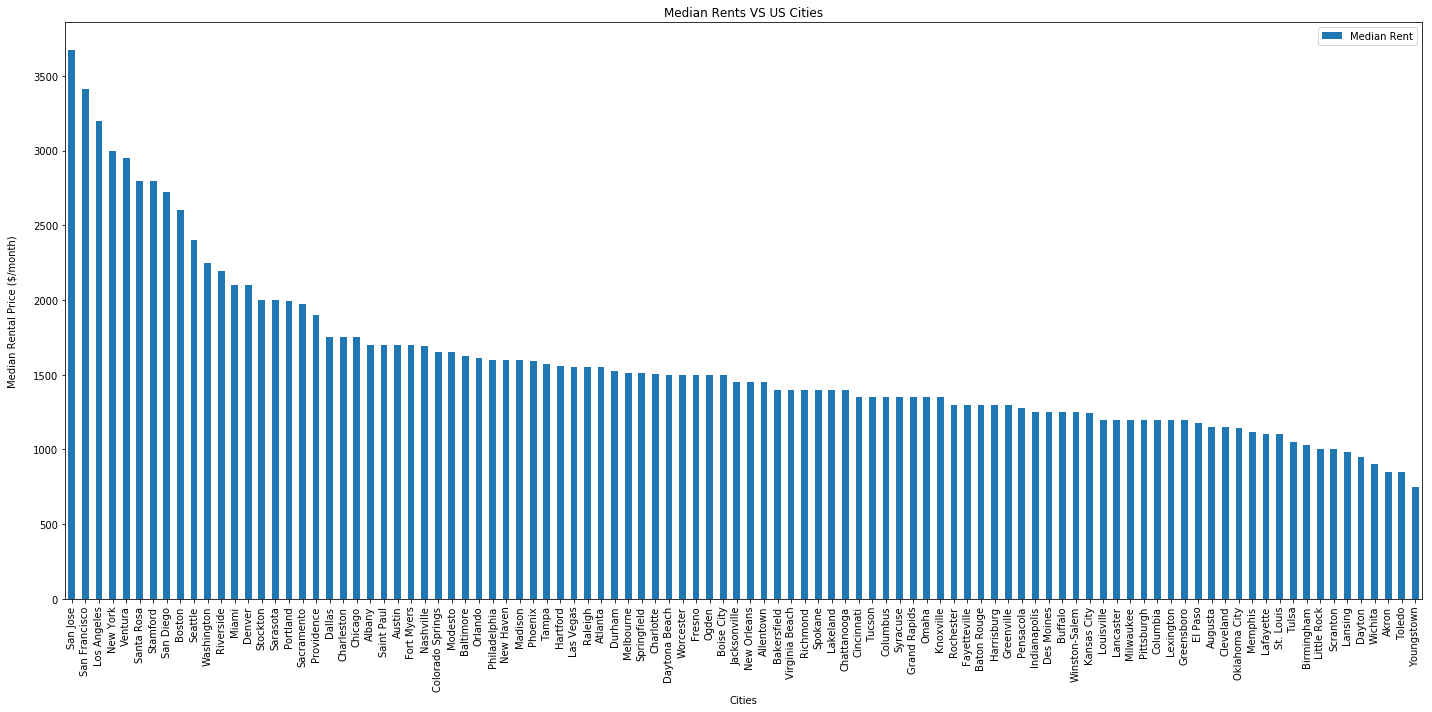

In [9]:
#Median Home Rents VS Cities
city_df = city_df.sort_values(by=['Median Rent'], ascending=False)   #sorted by median rent
city_df.plot(kind = "bar", x = "City", y= "Median Rent", figsize =(20,10)).set_ylabel("Median Rental($)")
plt.title("Median Rents VS US Cities")
plt.xlabel("Cities")
plt.ylabel("Median Rental Price ($/month)\n")
plt.tight_layout()
plt.savefig("images/Median Home Rent.png", bbox_inches = 'tight')
plt.show()

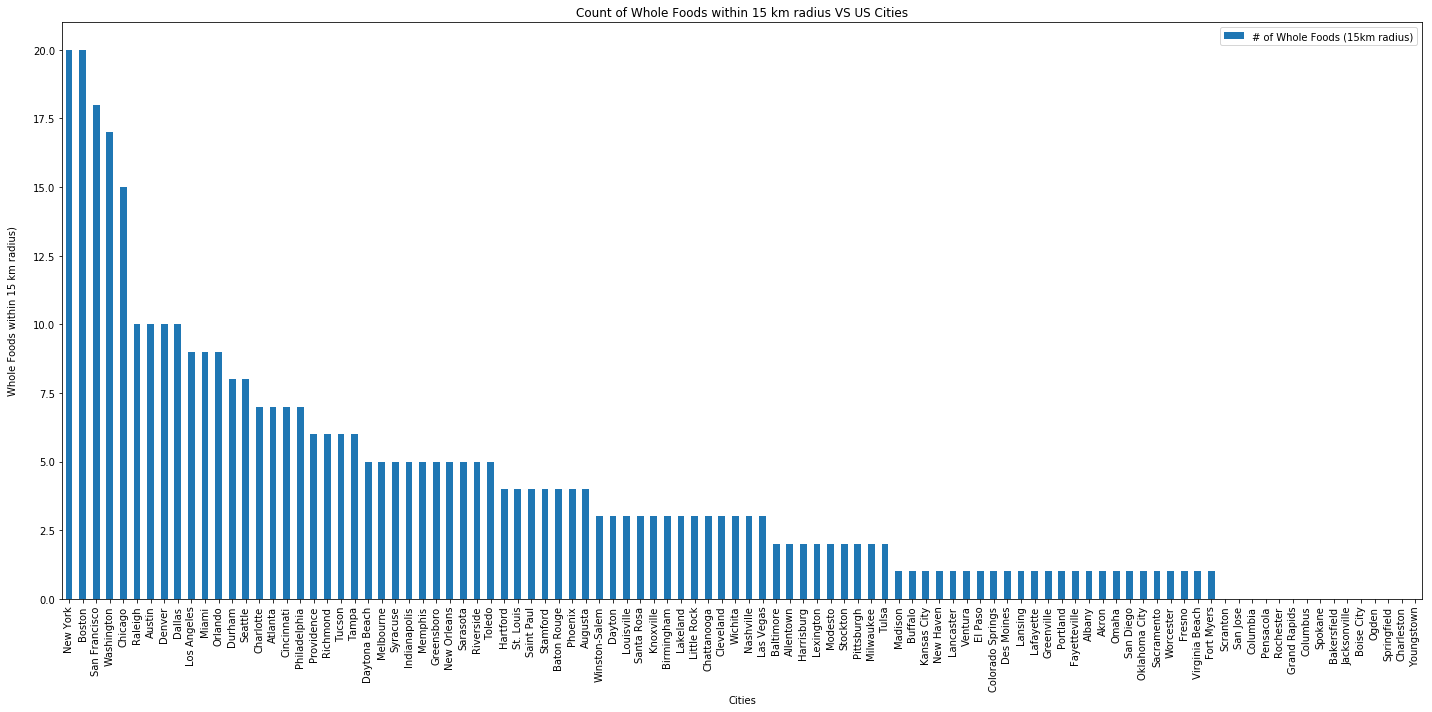

In [10]:
# Whole Foods count within 15 km radius per city
city_df = city_df.sort_values(by=['# of Whole Foods (15km radius)'], ascending=False) #sorted by # of whole foods
city_df.plot(kind = "bar", x = "City", y= "# of Whole Foods (15km radius)", figsize =(20,10)).set_ylabel("Median Sales Price($)")
plt.title("Count of Whole Foods within 15 km radius VS US Cities")
plt.xlabel("Cities")
plt.ylabel("Whole Foods within 15 km radius)\n")
plt.tight_layout()
plt.savefig("images/Citywise_Wholefoods.png", bbox_inches = 'tight')
plt.show()

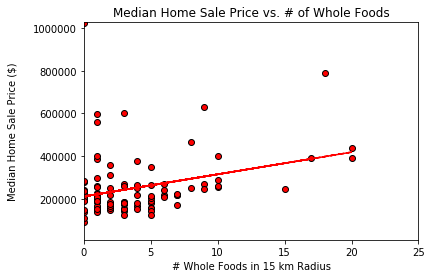

In [11]:
# Make scatter plot

df = pd.read_csv("datasets/top100_median_with_wf.csv")
df.head()

# Tell matplotlib to create a scatter plot based upon the above data

plt.scatter(df["# of Whole Foods (15km radius)"], df["Median Sale"], marker="o", color = "c", facecolors="red", edgecolors="black")

# Set the upper and lower limits of our y axis
plt.ylim(9000,1026000)

# Set the upper and lower limits of our x axis
plt.xlim(0,25)

# Create a title, x label, and y label for our chart

plt.title("Median Home Sale Price vs. # of Whole Foods")
plt.xlabel("# Whole Foods in 15 km Radius")
plt.ylabel("Median Home Sale Price ($)\n")

#add trendline for WF vs. Home Price
z = np.polyfit(df["# of Whole Foods (15km radius)"], df["Median Sale"], 1)
p = np.poly1d(z)
plt.plot(df["# of Whole Foods (15km radius)"],p(df["# of Whole Foods (15km radius)"]),"r--")


plt.savefig("images/MedianSale_WholeFoods_Scatter.png", bbox_inches = 'tight')

plt.show()

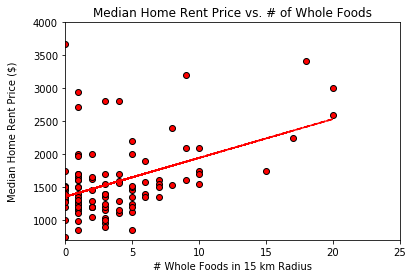

In [12]:
df = pd.read_csv("datasets/top100_median_with_wf.csv")
df.head()

# Tell matplotlib to create a scatter plot based upon the above data

plt.scatter(df["# of Whole Foods (15km radius)"], df["Median Rent"], marker="o", facecolors="red", edgecolors="black")

# Set the upper and lower limits of our y axis
plt.ylim(700,4000)

# Set the upper and lower limits of our x axis
plt.xlim(0,25)

# Create a title, x label, and y label for our chart

plt.title("Median Home Rent Price vs. # of Whole Foods")
plt.xlabel("# Whole Foods in 15 km Radius")
plt.ylabel("Median Home Rent Price ($)\n")

#add trendline for WF vs. Rent
z = np.polyfit(df["# of Whole Foods (15km radius)"], df["Median Rent"], 1)
p = np.poly1d(z)
plt.plot(df["# of Whole Foods (15km radius)"],p(df["# of Whole Foods (15km radius)"]),"r--")

plt.savefig("images/MedianRent_WholeFoods_Scatter.png", bbox_inches = 'tight')
plt.show()

In [13]:
############Make_Heatmap##################

#pandas read csv
my_cities_df = pd.read_csv('datasets/top100_median_with_wf.csv')
my_cities_df.head()

#get locations
locations = my_cities_df[["lat","lon"]]

#weights
my_weights = my_cities_df['Median Sale'].astype(float)
my_weights = my_weights/1000000   #google maps output is weird for large weights

# Configure gmaps with API key
gmaps.configure(api_key=gkey)

In [14]:
## Run any of the cell blocks below to create heatmaps

In [15]:
# Create a Median Sales heatmap 
fig1 = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights = my_weights, 
                                 dissipating=False, max_intensity=0.6,
                                 point_radius = 1)

fig1.add_layer(heat_layer)

fig1

Figure(layout=FigureLayout(height='420px'))

In [16]:
# Create a Median Rent heatmap 
fig2 = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights = my_cities_df['Median Rent'].astype(float)/3000, 
                                 dissipating=False, max_intensity=3.0,
                                 point_radius = 1)

fig2.add_layer(heat_layer)

fig2

Figure(layout=FigureLayout(height='420px'))

In [17]:
# Create a # of Whole Foods heatmap 
fig3 = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights = my_cities_df['# of Whole Foods (15km radius)'].astype(float)/20, 
                                 dissipating=False, max_intensity=1,
                                 point_radius = 1)

fig3.add_layer(heat_layer)

fig3

Figure(layout=FigureLayout(height='420px'))